In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import copy

from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import Aer, execute
from qiskit.circuit import Parameter
from qiskit.circuit import Gate
from qiskit.quantum_info.operators import Operator
from qiskit.visualization import plot_histogram

from scipy.optimize import minimize

In [2]:
file = 'test.txt'

lines = []
with open(file, 'r', errors='ignore') as f:
    lines = f.readlines()
    
f.close()

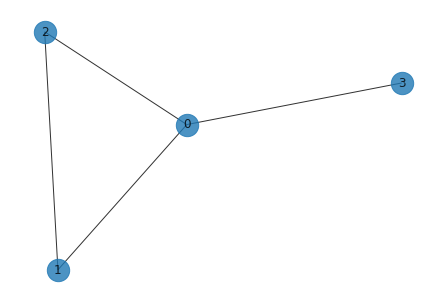

In [3]:
G = nx.Graph()

for line in lines:
    if (line[0] != '#'):
        data = line.split()
        if (len(data) == 3):
            G.add_edge(int(data[0]) - 1, int(data[1]) - 1, weight = int(data[2]))
            
adjacency_matrix = nx.to_numpy_matrix(G)
nx.draw(G, with_labels=True, alpha=0.8, node_size=500)

In [4]:
def maxcut_objective(x, G):
    objective = 0
    for i, j in G.edges():
        if (x[i] != x[j]):
            objective += G[i][j]["weight"]
            
    return objective

def bm_mc_objective(X, adjacency_matrix):
    # X is a numpy matrix of shape k x (number of vertices) 
    objective = 1 / 4 * (np.sum(adjacency_matrix) - np.trace(X @ adjacency_matrix @ X.T))
    
    return objective

In [5]:
def binary_string(x, n):
    binary = ""
    for _ in range(n):
        binary = str(x % 2) + binary
        x = x // 2
        
    return binary

def max_cut(G):
    n = len(G.nodes())
    
    optimal_cut = 0
    for x in range(2 ** n):
        binary = binary_string(x, n)
        optimal_cut = max(optimal_cut, maxcut_objective(binary, G))
        
    return optimal_cut

def find_optimal_cuts(G):
    n = len(G.nodes())
    optimal_cut = max_cut(G)
    
    optimal_cuts = []
    for x in range(2 ** n):
        binary = binary_string(x, n)
        if maxcut_objective(binary, G) == optimal_cut:
            optimal_cuts.append(binary)
            
    return optimal_cuts

# Optimal cuts for the graph instance
optimal_cuts = find_optimal_cuts(G)
optimal_cuts

['0011', '0101', '0111', '1000', '1010', '1100']

# Vanilla QAOA

In [6]:
def compute_expectation(counts, G):
    """
    Computes expectation value based on measurement results
    
    Args:
        counts: dict
                key as bitstring, val as count
           
        G: networkx graph
        
    Returns:
        avg: float
             expectation value
    """
    avg = 0
    sum_count = 0
    for bitstring, count in counts.items():   
        obj = -maxcut_objective(bitstring, G)
        avg += obj * count
        sum_count += count
        
    return avg/sum_count


# We will also bring the different circuit components that
# build the qaoa circuit under a single function
def create_qaoa_circuit(G, theta):
    """
    Creates a parametrized qaoa circuit
    
    Args:  
        G: networkx graph
        theta: list
               unitary parameters
                     
    Returns:
        qc: qiskit circuit
    """
    nqubits = len(G.nodes())
    p = len(theta) // 2  # number of alternating unitaries
    qc = QuantumCircuit(nqubits)
    
    beta = theta[:p]
    gamma = theta[p:]
    
    # initial_state
    for i in range(0, nqubits):
        qc.h(i)
    
    for irep in range(0, p):
        # problem unitary
        for i, j in G.edges():
            qc.rzz(2 * gamma[irep] * G[i][j]["weight"], i, j)

        # mixer unitary
        for i in range(0, nqubits):
            qc.rx(2 * beta[irep], i)
            
    qc.measure_all()
        
    return qc

# Finally we write a function that executes the circuit on the chosen backend
def get_expectation(G, p, shots=512):
    """
    Runs parametrized circuit
    
    Args:
        G: networkx graph
        p: int,
           Number of repetitions of unitaries
    """
    backend = Aer.get_backend('qasm_simulator')
    backend.shots = shots
    
    def execute_circuit(theta):
        qc = create_qaoa_circuit(G, theta)
        counts = backend.run(qc, seed_simulator=10, nshots=512).result().get_counts()
        return compute_expectation(counts, G)
    
    return execute_circuit

In [7]:
expectation = get_expectation(G, p=2)
res = minimize(expectation, [1.0, 1.0], method='COBYLA')
res

     fun: -3.951171875
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 31
  status: 1
 success: True
       x: array([-0.2333724 ,  0.88778785])

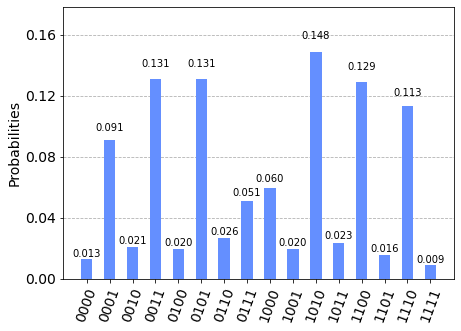

In [8]:
backend = Aer.get_backend('aer_simulator')
backend.shots = 512

qc_res = create_qaoa_circuit(G, res.x)
counts = backend.run(qc_res, seed_simulator=10).result().get_counts()
plot_histogram(counts)

# QAOA-Warm

In [9]:
def bm_mc_2(adjacency_matrix, iterations = 100, eta = 0.05):
    vertices = np.shape(adjacency_matrix)[0]
    thetas = np.random.uniform(low = 0, high = 2 * np.pi, size = vertices)
    # thetas = np.random.uniform(low = 0, high = np.pi, size = vertices)
    # print(thetas)
    
    stopping_threshold = np.sum(np.abs(adjacency_matrix))
    for _ in range(iterations):
        for vertex in range(vertices):
            X = np.array([np.cos(thetas), np.sin(thetas)])
            objective = bm_mc_objective(X, adjacency_matrix)

            perturbation = np.random.uniform(-eta, eta)
            new_thetas = copy.deepcopy(thetas)
            new_thetas[vertex] += perturbation
            new_X = np.array([np.cos(new_thetas), np.sin(new_thetas)])
            new_objective = bm_mc_objective(new_X, adjacency_matrix)
            if new_objective > objective:
                thetas = new_thetas
                
            # print(thetas)

    return thetas

def bm_mc_3(adjacency_matrix, iterations = 100, eta = 0.05):
    vertices = np.shape(adjacency_matrix)[0]
    thetas = np.random.uniform(low = 0, high = np.pi, size = vertices)
    phis = np.random.uniform(low = 0, high = 2 * np.pi, size = vertices)
    
    stopping_threshold = np.sum(np.abs(adjacency_matrix))
    for _ in range(iterations):
        for vertex in range(vertices):
            X = np.array([np.sin(thetas) * np.cos(phis), 
                          np.sin(thetas) * np.sin(phis), 
                          np.cos(thetas)])
            objective = bm_mc_objective(X, adjacency_matrix)

            theta_perturbation = np.random.uniform(-eta, eta)
            new_thetas = copy.deepcopy(thetas)
            new_thetas[vertex] += theta_perturbation
            
            phi_perturbation = np.random.uniform(-eta, eta)
            new_phis = copy.deepcopy(phis)
            new_phis += phi_perturbation
            
            new_X = np.array([np.sin(new_thetas) * np.cos(new_phis), 
                              np.sin(new_thetas) * np.sin(new_phis), 
                              np.cos(new_thetas)])
            new_objective = bm_mc_objective(new_X, adjacency_matrix)
            if new_objective > objective:
                thetas = new_thetas

    return thetas, phis

def hyperplane_rounding_2(thetas):
    # Choose a random normal
    random_normal_theta = np.random.uniform(low = 0, high = 2 * np.pi)
    random_normal = [[np.cos(random_normal_theta)], [np.sin(random_normal_theta)]]
    
    # Compute Cartesian coordinates
    X = np.array([np.cos(thetas), np.sin(thetas)])
    
    return (np.sum(X * random_normal, axis = 0) > 0) * 1

def hyperplane_rounding_3(thetas, phis):
    # Choose a random normal
    random_normal_theta = np.random.uniform(low = 0, high = np.pi)
    random_normal_phi = np.random.uniform(low = 0, high = 2 * np.pi)
    random_normal = np.array([[np.sin(random_normal_theta) * np.cos(random_normal_phi)], 
                              [np.sin(random_normal_theta) * np.sin(random_normal_phi)], 
                              [np.cos(random_normal_theta)]])
    
    # Compute Cartesian coordinates
    X = np.array([np.sin(thetas) * np.cos(phis), 
                  np.sin(thetas) * np.sin(phis), 
                  np.cos(thetas)])
    
    return (np.sum(X * random_normal, axis = 0) > 0) * 1

def solve_sdp_2(adjacency_matrix, iterations = 100, eta = 0.05):
    theta = bm_mc_2(adjacency_matrix, iterations, eta)
    return ''.join(map(str, hyperplane_rounding_2(theta)))

def solve_sdp_3(adjacency_matrix, iterations = 100, eta = 0.05):
    theta, phi = bm_mc_3(adjacency_matrix, iterations, eta)
    return ''.join(map(str, hyperplane_rounding_3(theta, phi)))

In [10]:
def success_rate_bm_mc_2(cases, optimal_cuts):
    successes = 0
    for _ in range(cases):
        if solve_sdp_2(adjacency_matrix) in optimal_cuts:
            successes += 1

    print("k = 2 Success Rate:", successes/cases)

def success_rate_bm_mc_3(cases, optimal_cuts):
    successes = 0
    for _ in range(cases):
        if solve_sdp_3(adjacency_matrix) in optimal_cuts:
            successes += 1

    print("k = 3 Success Rate:", successes/cases)

In [11]:
# Effect of theta initialisation range
# [0, pi]: Burer Monteiro MC Objective = 5.356300573724205
# [0, 2*pi]: BM_MC Objective = 5.499981867418311

In [12]:
cases = 20

success_rate_bm_mc_2(cases, optimal_cuts)
success_rate_bm_mc_3(cases, optimal_cuts)

k = 2 Success Rate: 1.0
k = 3 Success Rate: 0.9


In [13]:
def vertex_at_top_rotation_dim_2(thetas):
    vertices = np.shape(thetas)
    j = np.random.randint(low = 0, high = vertices)
    theta_j = thetas[j]
    return (thetas - theta_j)

def uniform_random_rotation_dim_2(thetas):
    random_theta = np.random.uniform(low = 0, high = 2 * np.pi)
    return (thetas + random_theta)

def vertex_at_top_rotation_dim_3(thetas, phis):
    vertices = np.shape(thetas)
    j = np.random.randint(low = 0, high = vertices)
    theta_j = thetas[j]
    phi_j = phis[j]
    return (thetas - theta_j), (phis - phi_j)

def uniform_random_rotation_dim_3(thetas, phis):
    random_theta = np.random.uniform(low = 0, high = np.pi)
    random_phi = np.random.uniform(low = 0, high = 2 * np.pi)
    return (thetas - random_theta), (phis - random_phi)

In [14]:
def create_warm_start_bm_mc_2(adjacency_matrix, uniform_rotation=False):
    # Initial state inspired by the Burer-Monteiro method
    warm_start_thetas = bm_mc_2(adjacency_matrix)
    
    # Checking if the solution returned corresponds to an optimal cut
    print("Cut returned by BM_MC_2:", hyperplane_rounding_2(warm_start_thetas))
    
    # Normalising angles and applying a random rotation 
    warm_start_thetas = np.mod(warm_start_thetas + 2 * np.pi, 2 * np.pi)
    
    if uniform_rotation:
        warm_start_thetas = uniform_random_rotation_dim_2(warm_start_thetas)
    else:
        warm_start_thetas = vertex_at_top_rotation_dim_2(warm_start_thetas)
        
    return warm_start_thetas

def create_qaoa_warm_circuit_bm_ck_2(G, theta, warm_start_thetas):
    """
    Creates a parametrized qaoa circuit
    
    Args:  
        G: networkx graph
        theta: list
               unitary parameters
                     
    Returns:
        qc: qiskit circuit
    """
    nqubits = len(G.nodes())
    adjacency_matrix = nx.to_numpy_matrix(G)
    
    p = len(theta) // 2  # number of alternating unitaries
    beta = theta[:p]
    gamma = theta[p:]
    
    qc = QuantumCircuit(nqubits)
    for i in range(0, nqubits):
        qc.rx(2 * np.pi - warm_start_thetas[i], i)
    
    for irep in range(0, p):
        # problem unitary
        for i, j in G.edges():
            qc.rzz(2 * gamma[irep] * G[i][j]["weight"], i, j)

        # mixer unitary
        for i in range(0, nqubits):
            qc.rx(2 * beta[irep], i)
            
    qc.measure_all()
    return qc

# Finally we write a function that executes the circuit on the chosen backend
def get_expectation(G, p, warm_start_thetas, shots=512):
    """
    Runs parametrized circuit
    
    Args:
        G: networkx graph
        p: int,
           Number of repetitions of unitaries
    """
    backend = Aer.get_backend('qasm_simulator')
    backend.shots = shots
    
    def execute_circuit(theta):
        qc = create_qaoa_warm_circuit_bm_ck_2(G, theta, warm_start_thetas)
        counts = backend.run(qc, seed_simulator=10, nshots=512).result().get_counts()
        return compute_expectation(counts, G)
    
    return execute_circuit

In [15]:
# Find the classically-inspired warm-start for k = 2
warm_start_thetas = create_warm_start_bm_mc_2(adjacency_matrix)

p = 2
expectation = get_expectation(G, p=p, warm_start_thetas=warm_start_thetas)
res = minimize(expectation, np.random.uniform(-0.0001, 0.0001, p), method='COBYLA')
res

Cut returned by BM_MC_2: [1 0 0 0]


     fun: -4.287109375
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 29
  status: 1
 success: True
       x: array([ 0.54849265, -0.0200682 ])

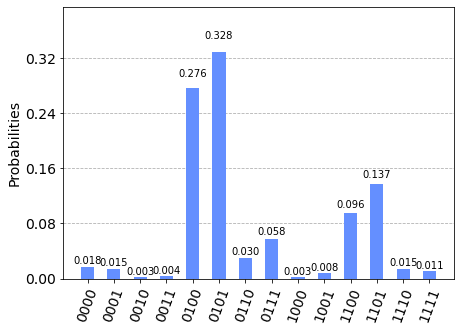

In [16]:
backend = Aer.get_backend('aer_simulator')
backend.shots = 512

qc_res = create_qaoa_warm_circuit_bm_ck_2(G, res.x, warm_start_thetas)
counts = backend.run(qc_res, seed_simulator=10).result().get_counts()
plot_histogram(counts)

In [17]:
def create_warm_start_bm_mc_3(adjacency_matrix, uniform_rotation=False):
    # Initial state inspired by the Burer-Monteiro method
    warm_start_thetas, warm_start_phis = bm_mc_3(adjacency_matrix)
    
    # Checking if the solution returned corresponds to an optimal cut
    print("Cut returned by BM_MC_3:", hyperplane_rounding_3(warm_start_thetas, warm_start_phis))
    
    # Normalising angles and applying a random rotation 
    warm_start_thetas = np.mod(warm_start_thetas + 2 * np.pi, 2 * np.pi)
    warm_start_phis = np.mod(warm_start_phis + 2 * np.pi, 2 * np.pi)
    
    if uniform_rotation:
        warm_start_thetas, warm_start_phis = uniform_random_rotation_dim_3(warm_start_thetas, warm_start_phis)
    else:
        warm_start_thetas, warm_start_phis = vertex_at_top_rotation_dim_3(warm_start_thetas, warm_start_phis)
        
    return warm_start_thetas, warm_start_phis


def create_qaoa_warm_circuit_bm_ck_3(G, theta, warm_start_thetas, warm_start_phis):
    """
    Creates a parametrized qaoa circuit
    
    Args:  
        G: networkx graph
        theta: list
               unitary parameters
                     
    Returns:
        qc: qiskit circuit
    """
    nqubits = len(G.nodes())
    adjacency_matrix = nx.to_numpy_matrix(G)
    
    p = len(theta) // 2  # number of alternating unitaries
    beta = theta[:p]
    gamma = theta[p:]
    
    qc = QuantumCircuit(nqubits)
    for i in range(0, nqubits):
        qc.u(warm_start_thetas[i], warm_start_phis[i], 0, i)
    
    for irep in range(0, p):
        # problem unitary
        for i, j in G.edges():
            qc.rzz(2 * gamma[irep] * G[i][j]["weight"], i, j)

        # mixer unitary
        for i in range(0, nqubits):
            qc.rx(2 * beta[irep], i)
            
    qc.measure_all()
    return qc

# Finally we write a function that executes the circuit on the chosen backend
def get_expectation(G, p, warm_start_thetas, warm_start_phis, shots=512):
    """
    Runs parametrized circuit
    
    Args:
        G: networkx graph
        p: int,
           Number of repetitions of unitaries
    """
    backend = Aer.get_backend('qasm_simulator')
    backend.shots = shots
    
    def execute_circuit(theta):
        qc = create_qaoa_warm_circuit_bm_ck_3(G, theta, warm_start_thetas, warm_start_phis)
        counts = backend.run(qc, seed_simulator=10, nshots=512).result().get_counts()
        return compute_expectation(counts, G)
    
    return execute_circuit

In [18]:
# Find the classically-inspired warm-start for k = 3
warm_start_thetas, warm_start_phis = create_warm_start_bm_mc_3(adjacency_matrix)

p = 2
expectation = get_expectation(G, p=p, warm_start_thetas=warm_start_thetas, warm_start_phis=warm_start_phis)
res = minimize(expectation, np.random.uniform(-0.0001, 0.0001, p), method='COBYLA')
res

Cut returned by BM_MC_3: [1 0 0 0]


     fun: -4.2646484375
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 41
  status: 1
 success: True
       x: array([1.17960079, 0.78830581])

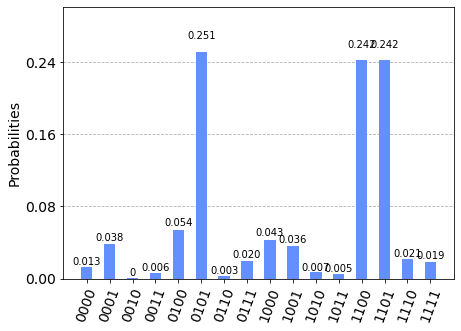

In [19]:
backend = Aer.get_backend('aer_simulator')
backend.shots = 512

qc_res = create_qaoa_warm_circuit_bm_ck_3(G, res.x, warm_start_thetas, warm_start_phis)
counts = backend.run(qc_res, seed_simulator=10).result().get_counts()
plot_histogram(counts)

# Modifying Mixer Hamiltonian

In [20]:
def create_qaoa_warmest_circuit_bm_ck_3(G, theta, warm_start_thetas, warm_start_phis):
    """
    Creates a parametrized qaoa circuit
    
    Args:  
        G: networkx graph
        theta: list
               unitary parameters
                     
    Returns:
        qc: qiskit circuit
    """
    nqubits = len(G.nodes())
    adjacency_matrix = nx.to_numpy_matrix(G)
    
    p = len(theta) // 2  # number of alternating unitaries
    beta = theta[:p]
    gamma = theta[p:]
    
    V = np.array([np.sin(warm_start_thetas) * np.cos(warm_start_phis), 
                  np.sin(warm_start_thetas) * np.sin(warm_start_phis), 
                  np.cos(warm_start_thetas)])
    
    # Defining the standard matrices
    I = np.eye(2)
    X = np.array([[0, 1],
                 [1, 0]])
    Y = np.array([[0, -1j], 
                  [1j, 0]])
    Z = np.array([[1, 0],
                  [0, -1]])
    
    qc = QuantumCircuit(nqubits)
    for i in range(0, nqubits):
        qc.u(warm_start_thetas[i], warm_start_phis[i], 0, i)
    
    for irep in range(0, p):
        # problem unitary
        for i, j in G.edges():
            qc.rzz(2 * gamma[irep] * G[i][j]["weight"], i, j)

        # mixer unitary
        for i in range(0, nqubits):
            (v_x, v_y, v_z) = V[:,i]
            custom_mixer_matrix = np.cos(beta[irep]) * I - 1j * np.sin(beta[irep]) * (v_x * X + v_y * Y + v_z * Z)
            custom_mixer = Operator(custom_mixer_matrix)
            qc.append(Operator(custom_mixer), [i])
            
    qc.measure_all()
    return qc

# Finally we write a function that executes the circuit on the chosen backend
def get_expectation(G, p, warm_start_thetas, warm_start_phis, shots=512):
    """
    Runs parametrized circuit
    
    Args:
        G: networkx graph
        p: int,
           Number of repetitions of unitaries
    """
    backend = Aer.get_backend('qasm_simulator')
    backend.shots = shots
    
    def execute_circuit(theta):
        qc = create_qaoa_warmest_circuit_bm_ck_3(G, theta, warm_start_thetas, warm_start_phis)
        counts = backend.run(qc, seed_simulator=10, nshots=512).result().get_counts()
        return compute_expectation(counts, G)
    
    return execute_circuit

In [21]:
# Find the classically-inspired warm-start for k = 3
warm_start_thetas, warm_start_phis = create_warm_start_bm_mc_3(adjacency_matrix)

p = 2
expectation = get_expectation(G, p=p, warm_start_thetas=warm_start_thetas, warm_start_phis=warm_start_phis)
res = minimize(expectation, np.random.uniform(-0.0001, 0.0001, p), method='COBYLA')
res

Cut returned by BM_MC_3: [1 1 0 1]


     fun: -2.4609375
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 13
  status: 1
 success: True
       x: array([ 5.26092852e-05, -6.29677039e-05])

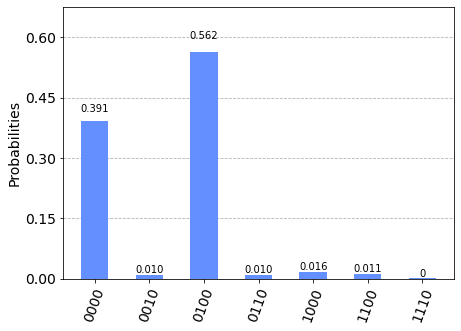

In [22]:
backend = Aer.get_backend('aer_simulator')
backend.shots = 512

qc_res = create_qaoa_warmest_circuit_bm_ck_3(G, res.x, warm_start_thetas, warm_start_phis)
counts = backend.run(qc_res, seed_simulator=10).result().get_counts()
plot_histogram(counts)